In [1]:
# This notebook is used to decide on a tolerable level of corruptableness.
%matplotlib inline

import numpy as np
from scipy.stats import entropy as KL_divergence
import pandas as pd
from itertools import product
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt

from slda.topic_models import GRTM
from modules.helpers import plot_images

2016-06-16 15:52:02.851924 start iterations
2016-06-16 15:52:03.456826 0:00:00.604902 elapsed, iter    1, LL -35066.3668, 8.76% change from last
2016-06-16 15:52:03.787649 0:00:00.935725 elapsed, iter    2, LL -33465.9023, 4.56% change from last
2016-06-16 15:52:04.116911 0:00:01.264987 elapsed, iter    3, LL -32470.6778, 2.97% change from last
2016-06-16 15:52:04.432527 0:00:01.580603 elapsed, iter    4, LL -31964.7792, 1.56% change from last
2016-06-16 15:52:04.773873 0:00:01.921949 elapsed, iter    5, LL -31280.6729, 2.14% change from last
2016-06-16 15:52:05.098530 0:00:02.246606 elapsed, iter    6, LL -30216.4994, 3.40% change from last
2016-06-16 15:52:05.431196 0:00:02.579272 elapsed, iter    7, LL -29313.7881, 2.99% change from last
2016-06-16 15:52:05.755323 0:00:02.903399 elapsed, iter    8, LL -28168.7845, 3.91% change from last
2016-06-16 15:52:06.075334 0:00:03.223410 elapsed, iter    9, LL -26432.6726, 6.16% change from last
2016-06-16 15:52:06.393178 0:00:03.541254 elaps

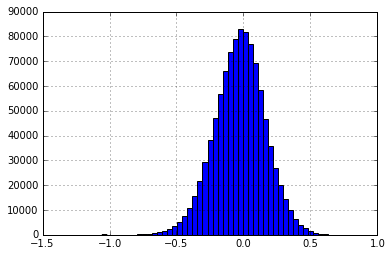

In [23]:
 # Generate topics
# We assume a vocabulary of 'rows'^2 terms, and create 'rows'*2 "topics",
# where each topic assigns exactly 'rows' consecutive terms equal probability.
rows = 3
V = rows * rows
K = rows * 2
N = K * K
D = 1000
seed = 42
topics = []
topic_base = np.concatenate((np.ones((1, rows)) * (1/rows),
                             np.zeros((rows-1, rows))), axis=0).ravel()
for i in range(rows):
    topics.append(np.roll(topic_base, i * rows))
topic_base = np.concatenate((np.ones((rows, 1)) * (1/rows),
                             np.zeros((rows, rows-1))), axis=1).ravel()
for i in range(rows):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)

# Generate documents from topics
# We generate D documents from these V topics by sampling D topic
# distributions, one for each document, from a Dirichlet distribution with
# parameter α=(1,…,1)
alpha = np.ones(K)
np.random.seed(seed)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=N, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1,
                                               p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V,
                                         range=(0, V - 1))[0] for d in range(D)])

# choose parameter values
mu = 0.
nu2 = 1.
np.random.seed(14)
H = np.random.normal(loc=mu, scale=nu2, size=(K, K))
zeta = pd.DataFrame([(i, j, np.dot(np.dot(thetas[i], H), thetas[j])) for i, j in product(range(D), repeat=2)],
                    columns=('tail', 'head', 'zeta'))
_ = zeta.zeta.hist(bins=50)

# choose parameter values
zeta['y'] = (zeta.zeta >= 0).astype(int)

y = zeta[['tail', 'head', 'y']].values

skf = StratifiedKFold(y[:, 2], n_folds=100)
_, train_idx = next(iter(skf))

# Estimate parameters
_K = K
_alpha = alpha[:_K]
_beta = np.repeat(0.01, V)
_mu = mu
_nu2 = nu2
_b = 1.
n_iter = 1000
grtm = GRTM(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42, n_report_iter=1)

grtm.fit(doc_term_matrix, y[train_idx])
results = grtm.phi

In [24]:
for res in results:
    minimized_KL = 1
    for topic in topics:
        KL = KL_divergence(topic, res)
        if KL < minimized_KL:
            minimized_KL = KL
    print(minimized_KL)

0.0360687572607
0.0201122685326
0.0812316413996
0.0236193602784
0.108897505098
0.175199332381


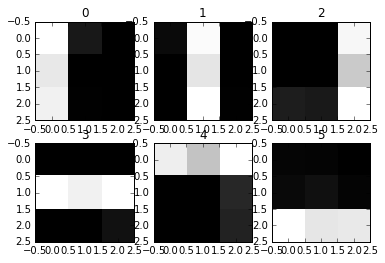

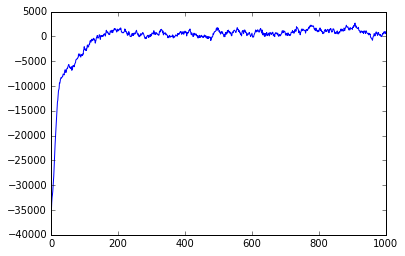

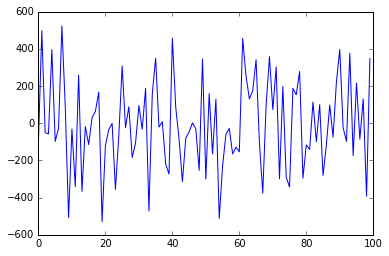

In [25]:
plot_images(plt, results, (rows, rows), (2, rows))
plt.figure()
plt.plot(grtm.loglikelihoods)
plt.figure()
plt.plot(np.diff(grtm.loglikelihoods)[-100:])